In [1]:
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload the kaggle.json API key manually or using the following code
from google.colab import files
files.upload()  # Upload your kaggle.json

# Step 3: Set up Kaggle API credentials
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# Step 4: Download the dataset#!/bin/bash
! kaggle datasets download jp797498e/twitter-entity-sentiment-analysis

# Step 5: Unzip the dataset if necessary
!unzip /content/twitter-entity-sentiment-analysis -d /content/twitter-entity-sentiment-analysis

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 70.5MB/s]
Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: /content/twitter-entity-sentiment-analysis/twitter_training.csv  
  inflating: /content/twitter-entity-sentiment-analysis/twitter_validation.csv  


In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Load training & validation datasets
train_df = pd.read_csv("/content/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)
val_df = pd.read_csv("/content/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)

# Assign column names
train_df.columns = ["id", "entity", "sentiment", "text"]
val_df.columns = ["id", "entity", "sentiment", "text"]

# Combine datasets
df = pd.concat([train_df, val_df], ignore_index=True)

# Display dataset info
print("\n Dataset Loaded! Shape:", df.shape)
print(df.head())

# Check for missing values
print("\n Checking Missing Values:\n", df.isnull().sum())

# Fill missing values
df.fillna("", inplace=True)



 Dataset Loaded! Shape: (75682, 4)
     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

 Checking Missing Values:
 id             0
entity         0
sentiment      0
text         686
dtype: int64


In [5]:
train_df.shape

(74682, 4)

In [6]:
train_df.isna().sum()

,0
id,0
entity,0
sentiment,0
text,686


In [7]:
train_df.duplicated().sum()

2700

In [8]:
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
train_df.shape

(71656, 4)

In [9]:
import re

def clean_text(text):
    # Convert all text to lowercase
    text = text.lower()

    # Remove links/URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove emojis and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove punctuation and other symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove numbers (optional, remove this line if you want to keep numbers)
    text = re.sub(r'\d+', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Normalize words
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "i am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'unk' , ' ' , text)

    return text

train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)


In [ ]:
train_df.sample(5)

,id,entity,sentiment,text
44958,11721,Verizon,Negative,this is ridiculous pic twitter com tnehzobjs
8807,9510,Overwatch,Irrelevant,on overwatch league television set where the c...
72989,8902,Nvidia,Neutral,stayed up late night and order the psp graphic...
4858,35,Amazon,Positive,i certainly am so lucky to work hard for a com...
64912,7918,MaddenNFL,Negative,for maddenleagueops maddennfldirect sad


In [10]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Initialize the stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Additional stop words list
# additional_stop_words = ['im']
# stop_words.update(additional_stop_words)

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# Apply preprocessing to all text
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)


In [ ]:
train_df.sample(5)

,id,entity,sentiment,text
32999,6462,Fortnite,Positive,noth scream left wing agenda like old ol fortnit
24330,4573,Google,Negative,tuckercarlson tonight fail mention elizabeth w...
69847,3967,Cyberpunk2077,Neutral,think happi result soon big pictur good challe...
29315,641,ApexLegends,Neutral,silver kill
4368,1952,CallOfDutyBlackopsColdWar,Positive,randomli went end game man miss game


In [11]:
# Filter positive sentiment words
positive_words = train_df[train_df['sentiment'] == 'Positive']
positive_sentiment = positive_words['text']

# Filter negative sentiment words
negative_words = train_df[train_df['sentiment'] == 'Negative']
negative_sentiment = negative_words['text']

# Filter neutral sentiment words
neutral_words = train_df[train_df['sentiment'] == 'Neutral']
neutral_sentiment = neutral_words['text']

# Filter irrelevant sentiment words
irrelevant_words = train_df[train_df['sentiment'] == 'Irrelevant']
irrelevant_sentiment = irrelevant_words['text']


<ipython-input-12-c3e43e3ba11b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_df, x='sentiment', palette="Set2", edgecolor="black")


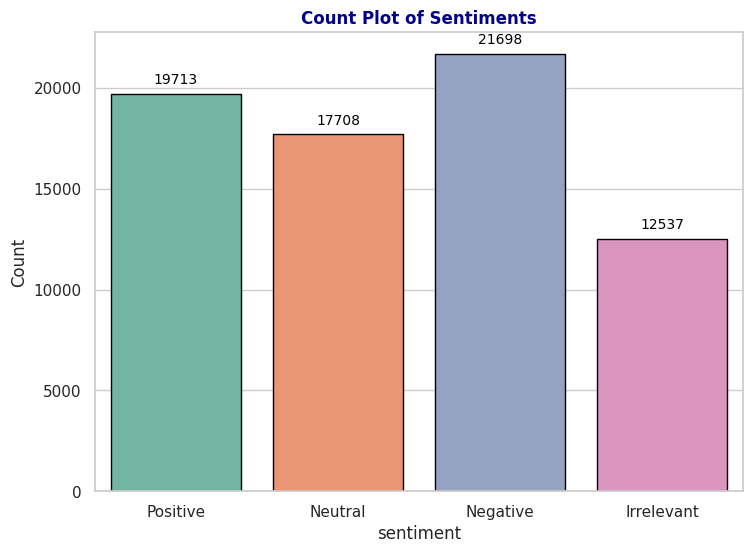

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(8, 6))

# Set Seaborn style
sns.set(style="whitegrid")

# Create a count plot for sentiment distribution
ax = sns.countplot(data=train_df, x='sentiment', palette="Set2", edgecolor="black")

# Set title and labels
plt.title('Count Plot of Sentiments', fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points',
                fontsize=10, color='black')

# Adjust layout and show plot
plt.tight_layout(pad=2)
plt.show()


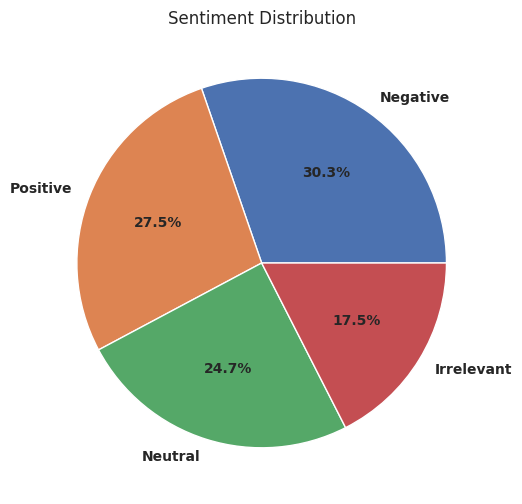

In [13]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(6, 6))

# Create a pie chart for sentiment distribution
plt.pie(
    x=train_df['sentiment'].value_counts().values,
    labels=train_df['sentiment'].value_counts().keys(),
    autopct="%1.1f%%",
    textprops={"fontsize": 10, "fontweight": "black"}
)

# Set title and show the plot
plt.title('Sentiment Distribution')
plt.show()


<ipython-input-14-ab9f06b0c7f2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


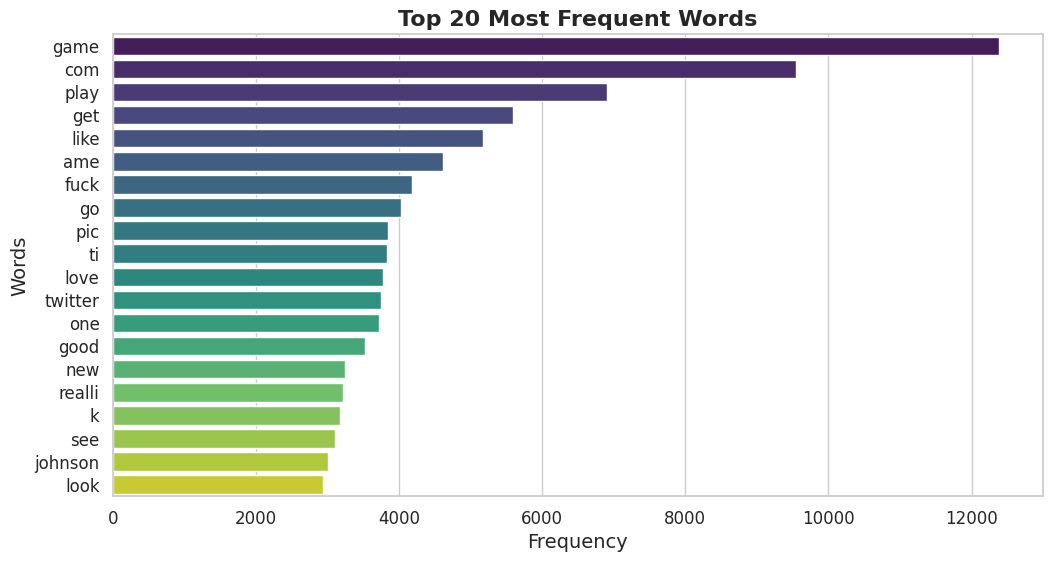

In [14]:


# Combine all text into a single string
text = " ".join(train_df["text"])
tokens = text.split()

# Count the frequency of each word
word_counts = Counter(tokens)

# Get the most frequently occurring words
top_words = word_counts.most_common(20)  # Get the top 20 words

# --- Visualization 1: Bar Chart ---
# Separate words and their counts
words, counts = zip(*top_words)

# Set Seaborn theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words", fontsize=16, fontweight='bold')
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


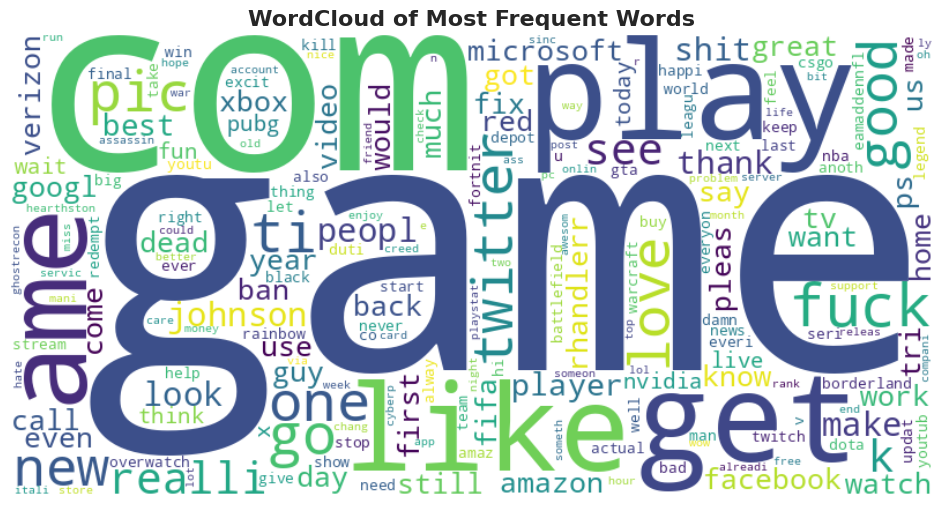

In [15]:


# Generate WordCloud from word frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(word_counts)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Most Frequent Words", fontsize=16, fontweight='bold')
plt.show()


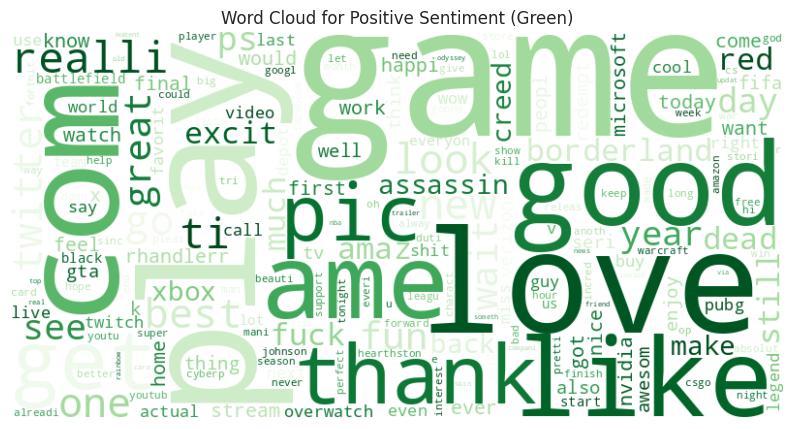

In [16]:
# Combine all positive sentiment text into a single string
positive_text = ' '.join(positive_sentiment)

# Tokenize words and count frequency for positive sentiment
positive_words = positive_text.split()
positive_word_counts = Counter(positive_words)

# Display the most common words for positive sentiment
common_positive_words = positive_word_counts.most_common(10)

# Create a word cloud for positive sentiment with a green colormap
wordcloud_positive = WordCloud(
    width=800, height=400, background_color='white', colormap='Greens'
).generate_from_frequencies(positive_word_counts)

# Plot the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment (Green)")
plt.show()

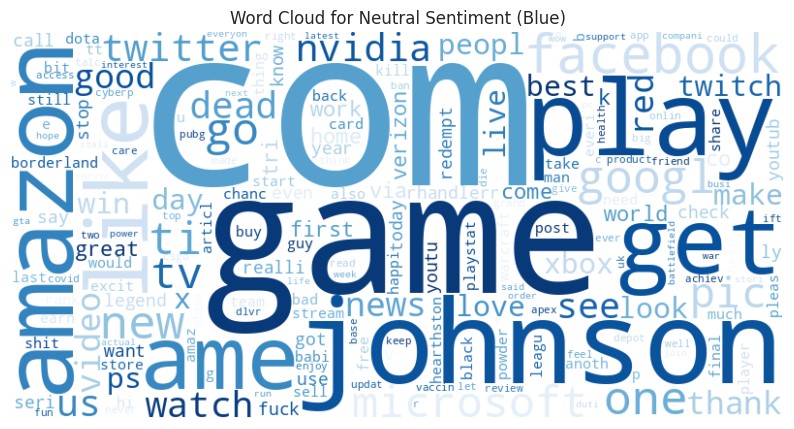

In [17]:
# Combine all neutral sentiment text into a single string
neutral_text = ' '.join(neutral_sentiment)

# Tokenize words and count frequency for neutral sentiment
neutral_words = neutral_text.split()
neutral_word_counts = Counter(neutral_words)

# Display the most common words for neutral sentiment
common_neutral_words = neutral_word_counts.most_common(10)

# Create a word cloud for neutral sentiment with a blue colormap
wordcloud_neutral = WordCloud(
    width=800, height=400, background_color='white', colormap='Blues'
).generate_from_frequencies(neutral_word_counts)

# Plot the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Neutral Sentiment (Blue)")
plt.show()

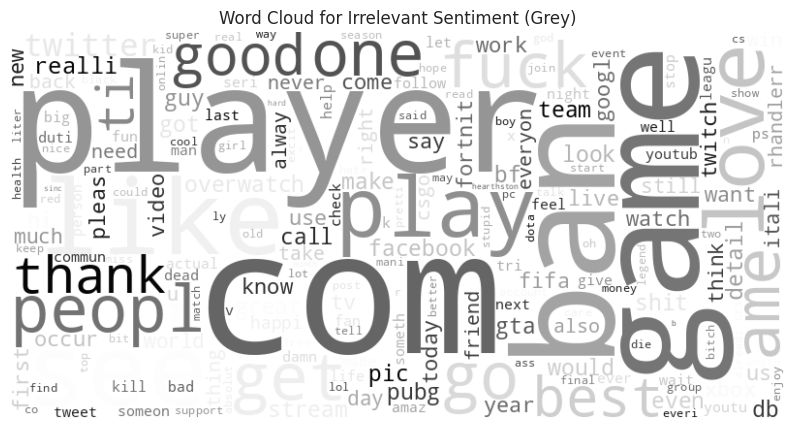

In [ ]:
# Join all the positive and negative reviews into single strings
kata_irrelevant = ' '.join(sentimen_irrelevant)

# Tokenize the words and count frequency for negative sentiment
words_irrelevant = kata_irrelevant.split()
word_counts_irrelevant = Counter(words_irrelevant)

# Display the most common words for negative sentiment
common_words_irrelevant = word_counts_irrelevant.most_common(10)

# Create word cloud for negative sentiment with a red colormap
wordcloud_irrelevant = WordCloud(
    width=800, height=400, background_color='white', colormap='Greys').generate_from_frequencies(word_counts_irrelevant)

# Plotting the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Irrelevant Sentiment (Grey)")
plt.show()

In [19]:
# Select only the 'text' and 'sentiment' columns
train_df = train_df[['text', 'sentiment']]

# Display a random sample of 5 rows
train_df.sample(5)


,text,sentiment
27302,beninscreen odyssey love game much nintendo sw...,Positive
47288,right right right,Irrelevant
2045,borderland suck updat onbovcewovq actual sadli...,Negative
14021,god u beat acc pl got ban year k conducut like u,Irrelevant
28391,cours readi save,Negative


In [20]:
# Select only the 'text' and 'sentiment' columns
valid_df = val_df[['text', 'sentiment']]

# Display a random sample of 5 rows
valid_df.sample(5)


,text,sentiment
279,epicgamestr fortnitegam save world glithc get ...,Negative
483,love list,Positive
381,amaz mainstream media tri normalis musli cri a...,Irrelevant
390,mori,Neutral
750,final finish red dead redempt nearli year half...,Positive


In [21]:
# Map sentiment labels to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2}

train_df['sentiment'] = train_df['sentiment'].map(sentiment_mapping)
valid_df['sentiment'] = valid_df['sentiment'].map(sentiment_mapping)


<ipython-input-21-706a449f02c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['sentiment'] = valid_df['sentiment'].map(sentiment_mapping)


In [22]:
# Extract text and sentiment values as NumPy arrays
train_texts, train_labels = train_df['text'].values, train_df['sentiment'].values
val_texts, val_labels = valid_df['text'].values, valid_df['sentiment'].values


In [23]:

# Initialize the tokenizer with a vocabulary size limit
tokenizer = Tokenizer(num_words=10000)  # Adjust the maximum number of words

# Fit the tokenizer only on the training data
tokenizer.fit_on_texts(train_texts)

# Convert text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Define the maximum sequence length
max_sequence_length = 100

# Pad sequences to ensure uniform input length
X = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)


In [24]:
import pickle

# Save the tokenizer to a file
with open('tokenizer2.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer has been saved.")


Tokenizer has been saved.


In [26]:
from sklearn.model_selection import train_test_split

# Split the training data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, train_labels, test_size=0.1, random_state=42
)


In [27]:


# Convert datasets to NumPy arrays
X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)
train_labels, test_labels, val_labels = np.array(y_train), np.array(y_test), np.array(val_labels)


In [28]:
# Define the LSTM model
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    layers.LSTM(64, return_sequences=True),
    # layers.Dropout(0.2),  # Optional dropout
    layers.LSTM(32),
    layers.Dropout(0.2),
    # Dense(32, activation='relu'),  # Optional dense layer
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model using sparse categorical cross-entropy loss
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(
    X_train, train_labels,
    validation_data=(X_val, val_labels),
    epochs=10,
    batch_size=64,
    verbose=1  # Display training progress
)


Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 216s 207ms/step - accuracy: 0.5958 - loss: 0.8409 - val_accuracy: 0.8730 - val_loss: 0.3726
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 237s 182ms/step - accuracy: 0.8303 - loss: 0.4221 - val_accuracy: 0.9010 - val_loss: 0.3046
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 183s 182ms/step - accuracy: 0.8838 - loss: 0.2927 - val_accuracy: 0.9180 - val_loss: 0.2842
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 205s 185ms/step - accuracy: 0.9059 - loss: 0.2317 - val_accuracy: 0.9270 - val_loss: 0.2927
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 200s 183ms/step - accuracy: 0.9196 - loss: 0.1988 - val_accuracy: 0.9340 - val_loss: 0.3482
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 201s 182ms/step - accuracy: 0.9305 - loss: 0.1710 - val_accuracy: 0.9310 - val_loss: 0.3599
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 201s 181ms/step - accuracy: 0.9392 - loss: 0.1476 - val_accuracy: 0.9310 - val_loss: 0.3842
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 216s 195ms/step - ac

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, test_labels)

# Print test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.8803 - loss: 0.4412
Test Accuracy: 88.03%


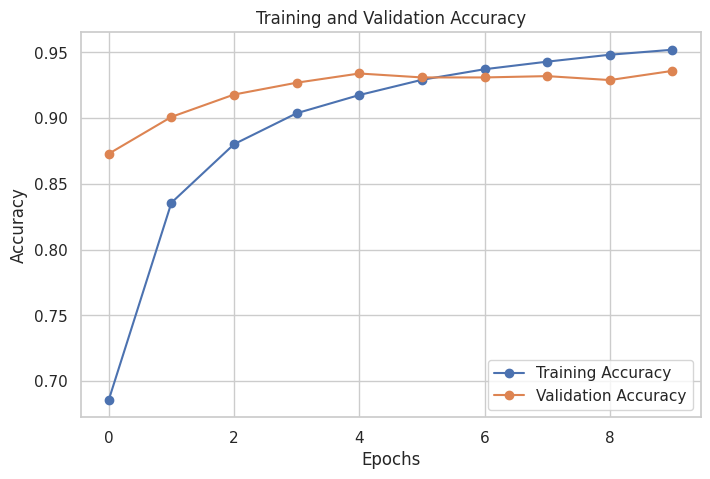

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step


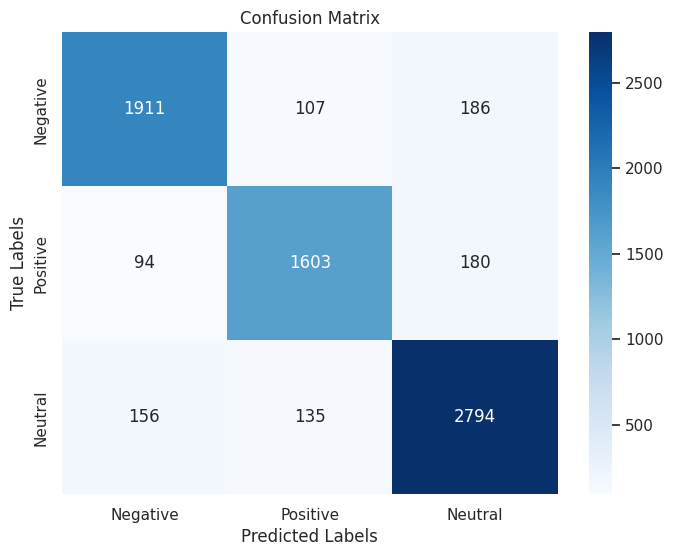

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1) if y_pred_probs.ndim > 1 else y_pred_probs
y_true_labels = np.argmax(test_labels, axis=1) if test_labels.ndim > 1 else test_labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
model.save('model.h5')

In [42]:
pip install pyngrok


In [43]:
from pyngrok import ngrok


In [47]:
pip install flask pyngrok tensorflow numpy


In [49]:
import os
import numpy as np
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set ngrok authentication token
NGROK_AUTH_TOKEN = "2sAS7yHBpbbFZcQD2GcUdaLOCgO_3fM2kKzd1jjPhzCMvbouz"

# Load trained sentiment analysis model
model_path = "/content/model.h5"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please upload the model file.")

model = tf.keras.models.load_model(model_path, compile=False)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Load tokenizer
with open("/content/tokenizer2.pkl", "rb") as file:
    tokenizer = pickle.load(file)

# Define max sequence length (same as used during training)
max_sequence_length = 100

# Initialize Flask app
app = Flask(__name__)

# Start ngrok tunnel
ngrok.set_auth_token(NGROK_AUTH_TOKEN)  # Authenticate ngrok
public_url = ngrok.connect(5000).public_url
print(f" * ngrok tunnel available at: {public_url}")

# Sentiment labels mapping
sentiment_labels = {0: "Negative", 1: "Positive", 2: "Neutral"}

# HTML Interface (Embedded in Flask)
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Sentiment Analysis</title>
    <style>
        body { font-family: Arial, sans-serif; text-align: center; padding: 50px; }
        input, button { padding: 10px; font-size: 16px; margin: 10px; }
    </style>
</head>
<body>
    <h2>Sentiment Analysis</h2>
    <form method="post">
        <input type="text" name="text" placeholder="Enter text" required>
        <button type="submit">Analyze</button>
    </form>
    {% if sentiment %}
        <h3>Prediction: {{ sentiment }}</h3>
    {% endif %}
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def home():
    sentiment = None
    if request.method == "POST":
        text = request.form.get("text")
        if text:
            # Preprocess input text
            seq = tokenizer.texts_to_sequences([text])
            padded_seq = pad_sequences(seq, maxlen=max_sequence_length)

            # Make prediction
            prediction = model.predict(padded_seq)
            predicted_label = np.argmax(prediction)
            confidence = np.max(prediction) * 100  # Convert to percentage

            sentiment = f"{sentiment_labels[predicted_label]} (Confidence: {confidence:.2f}%)"

    return render_template_string(HTML_TEMPLATE, sentiment=sentiment)

if __name__ == "__main__":
    app.run(port=5000)


 * ngrok tunnel available at: https://40e5-34-136-44-134.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:05:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:05:27] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:06:01] "POST / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:06:16] "POST / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:06:29] "POST / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:06:38] "POST / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


INFO:werkzeug:127.0.0.1 - - [27/Feb/2025 06:06:54] "POST / HTTP/1.1" 200 -
